# plot_LAI_data
- this needs to be done becuase i know less about this than ecmwf as a robust source
- compare the seasonality of historical CMIP5 LAI to that observed by AVHRR
- show the time series of the simulated LAI data to check for wierdness

**NOTE:** Based on the tasks above, I think it makes sense to remove ACCESS1-0 and ACCESS1-3, as the LAI data for this model are clearly prescribed and do not change over time. 

In [1]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import os
import glob

In [2]:
# Get the SW_monthly_mean LAI

In [3]:
AVHRR_LAI = pd.read_csv(os.path.join("..","Data","LAI", "SW_monthly_mean_LAI.csv"))
AVHRR_LAI.iloc[:4,:]

,Unnamed: 0,year,month,LAI
0,0,1983,1,0.179576
1,1,1983,2,0.188919
2,2,1983,3,0.276118
3,3,1983,4,0.342592


In [4]:
# Get the CMIP5 equivalent to compare to

In [5]:
import met_spread_utils as msu

In [6]:
?msu.get_cmip5_nc

Signature: msu.get_cmip5_nc(var, rcp, model, spatial_mask, spatial_mean=False, inspect=False)
Docstring:
This function will be for loading a particular CMIP5 NetCDF file, which will be spatially subset 
by this function. These CMIP5 model output to be loaded have been regridded to the "Common grid" 
using $ cdo remapbil. Defualts to taking the spatial mean of all global data for the var argument. 
Change area loaded using the minX, maxX, etc. arguments. 

Parameters
----------
    var : str, The CMIP5 variable name to be loaded. File names match variable names. 
    rcp : str, "45" or "85", refers to representative concentration pathway. 
    model : The name of the model that created the var, to be loaded from. 
    spatial_mask : numpy array, where equal to 1 (True) are locations to mask, meaning
                   they will NOT be used in calculations, spatial means, etc. 
    spatial_mean : Boolean, if False (default) the data  will be returned on a 
                   [t, lon, lat

In [11]:
files = glob.glob(os.path.join("..", "Data","CMIP5", "r1i1p1_rcp_COMMON_GRID", "lai_*"))
files[0]

'../Data/CMIP5/r1i1p1_rcp_COMMON_GRID/lai_Lmon_ACCESS1-0_rcp45_r1i1p1_198301-210012.nc'

In [17]:
files = glob.glob(os.path.join("..", "Data","CMIP5", "r1i1p1_rcp_COMMON_GRID", "lai_*"))
models = []
for f in files :
    models.append(f.split("/")[4].split("_")[2])
models=np.unique(np.array(models))

In [18]:
lai_45 = {}


array(['ACCESS1-0', 'ACCESS1-3', 'CCSM4', 'CMCC-CESM', 'CanESM2',
       'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'IPSL-CM5A-LR',
       'IPSL-CM5A-MR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5',
       'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-ESM1', 'NorESM1-ME',
       'bcc-csm1-1-m', 'inmcm4'], dtype='<U14')

In [40]:
mask = np.zeros( shape=(90, 144))
mask = np.array(mask, dtype=bool)

In [41]:
mask.shape

(90, 144)

In [42]:
np.unique(mask)

array([False])

In [43]:
valsCut, t_mon, lon, lat = msu.get_cmip5_nc("lai", "85", 'ACCESS1-0', mask)

In [44]:
valsCut.shape

(1416, 90, 144)

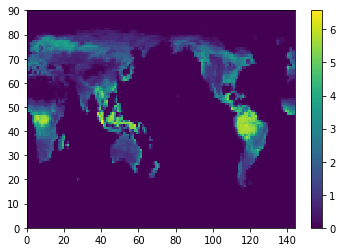

In [45]:
plt.pcolor(valsCut.mean(axis=0))
plt.colorbar()

Load the SW region mask 

In [122]:
nc = Dataset(os.path.join("..","Data","LandCover", "SW_region_mask_common_grid.nc"))
SW_region_common_grid = nc.variables["SW_Mask"][:]
nc.close()

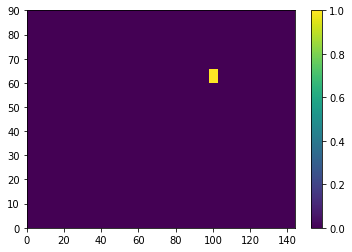

In [123]:
plt.pcolor(SW_region_common_grid)
plt.colorbar()

In [124]:
valsCut, t_mon, lon, lat = msu.get_cmip5_nc("lai", "85", 'ACCESS1-0', spatial_mask=SW_region_common_grid==0)

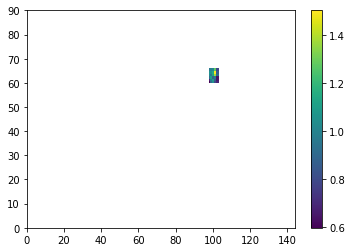

In [125]:
plt.pcolor(valsCut.mean(axis=0))
plt.colorbar()

In [128]:
lai_85 = {}
lai_month_std = pd.DataFrame(np.nan, index=(np.arange(1,13)), columns=models) 
lai_month_mean = pd.DataFrame(np.nan, index=(np.arange(1,13)), columns=models)

for model in models :
    
    try : 
        valsCut, t_mon, lon, lat = msu.get_cmip5_nc("lai", "45", model, spatial_mask=SW_region_common_grid==0)
    except :
        ValueError("lai not available for %s" %model)
    
    lai_ = valsCut.mean(axis=(1,2))
    mon_ = t_mon.month
    
    # Mask out the historical period 
    hist_mask = (t_mon.year >= 1983) & (t_mon.year <= 2015)
    
    lai_85[model] = lai_
    # Calculate monthly std, when they are 0 or close to zero that means LAI is 
    # not evolving and these estimates are useless! 
    lai_month_std.loc[:, model] = pd.DataFrame({"mon":mon_, "lai":lai_}).groupby(["mon"]).std().values
    lai_month_mean.loc[:, model] = pd.DataFrame({"mon":mon_[hist_mask], "lai":lai_[hist_mask]}).groupby(["mon"]).mean().values
    
    

In [150]:
lai_month_std

,ACCESS1-0,ACCESS1-3,CCSM4,CMCC-CESM,CanESM2,GFDL-CM3,GFDL-ESM2G,GFDL-ESM2M,IPSL-CM5A-LR,IPSL-CM5A-MR,MIROC-ESM,MIROC-ESM-CHEM,MIROC5,MPI-ESM-LR,MPI-ESM-MR,MRI-ESM1,NorESM1-ME,bcc-csm1-1-m,inmcm4
1,0.000000,0.000000,0.198889,0.198889,0.017340,0.109152,0.063765,0.068322,0.197017,0.198845,0.209062,0.159777,0.000564,0.121793,0.133666,0.133666,0.212424,0.114500,20.926140
2,0.000197,0.000110,0.209788,0.209788,0.015111,0.156817,0.071218,0.069111,0.176455,0.180285,0.198889,0.164690,0.000576,0.138170,0.133696,0.133696,0.226689,0.128656,23.095222
3,0.000249,0.000131,0.214234,0.214234,0.021477,0.260242,0.174696,0.144791,0.173149,0.188346,0.268581,0.286118,0.000841,0.152617,0.136463,0.136463,0.224719,0.157696,23.034838
4,0.000000,0.000000,0.215629,0.215629,0.033175,0.384931,0.354504,0.245553,0.189620,0.209235,0.386219,0.489501,0.001137,0.153567,0.139292,0.139292,0.223195,0.204553,27.172320
5,0.000000,0.000000,0.222631,0.222631,0.053850,0.512587,0.475674,0.411606,0.206038,0.231308,0.268465,0.403250,0.001527,0.104667,0.103451,0.103451,0.230823,0.271828,22.497496
6,0.000000,0.000000,0.222307,0.222307,0.067173,0.509700,0.541949,0.532021,0.206509,0.248889,0.261417,0.380244,0.001859,0.094051,0.085479,0.085479,0.223387,0.332489,18.900134
7,0.000000,0.000000,0.227548,0.227548,0.069474,0.389705,0.621495,0.520004,0.206068,0.238699,0.313271,0.344868,0.001840,0.130668,0.114454,0.114454,0.219650,0.341172,15.923004
8,0.000000,0.000000,0.224486,0.224486,0.080189,0.382439,0.641801,0.547866,0.200968,0.226620,0.340881,0.329405,0.001855,0.165898,0.157380,0.157380,0.232307,0.321580,13.991022
9,0.000000,0.000000,0.234425,0.234425,0.090820,0.406734,0.658492,0.602861,0.206857,0.229030,0.296715,0.309525,0.001672,0.173595,0.166757,0.166757,0.229830,0.194900,18.559135
10,0.000000,0.000000,0.231488,0.231488,0.103943,0.456408,0.688876,0.609903,0.207683,0.234957,0.245789,0.316708,0.001176,0.170011,0.171222,0.171222,0.207973,0.110782,27.863304


Plot obs and modeled values together

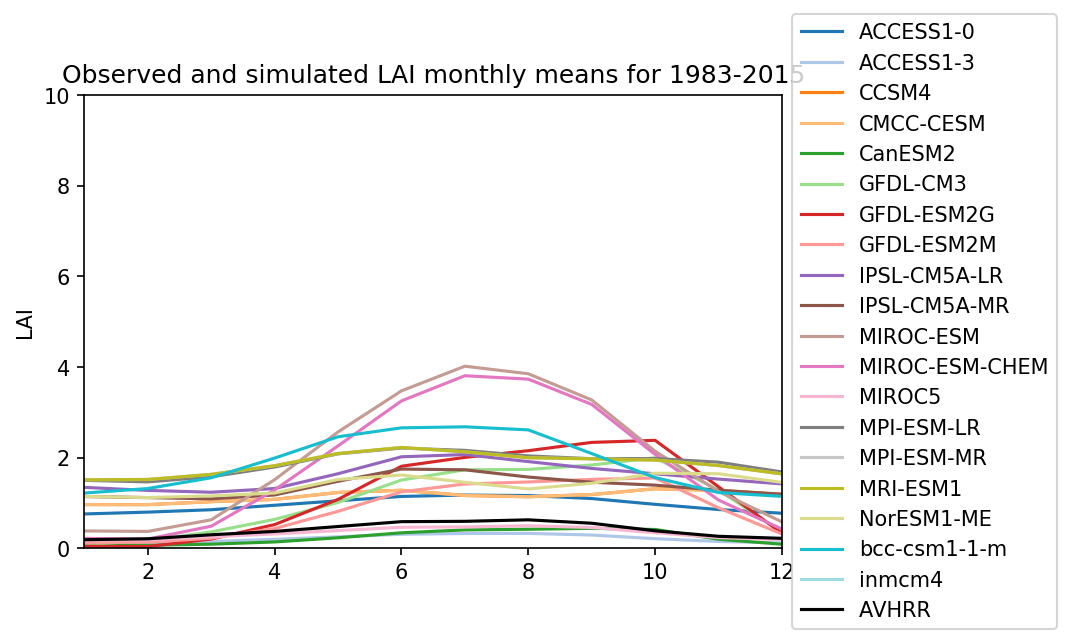

In [143]:
plt.figure(dpi=150)

ax=plt.subplot(111)
ax1=lai_month_mean.plot(cmap="tab20", ylim=(0,10), ax=ax)

# Handle the legend
plt.plot(AVHRR_LAI[ ["month", "LAI"] ].groupby(["month"]).mean(), c="k",  label="AVHRR")
plt.legend()

ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title("Observed and simulated LAI monthly means for 1983-2015")
plt.ylabel("LAI")
plt.show()

In [145]:
lai_85_df = pd.DataFrame(lai_85, index=t_mon)
lai_85_df.iloc[:4,:]

,ACCESS1-0,ACCESS1-3,CCSM4,CMCC-CESM,CanESM2,GFDL-CM3,GFDL-ESM2G,GFDL-ESM2M,IPSL-CM5A-LR,IPSL-CM5A-MR,MIROC-ESM,MIROC-ESM-CHEM,MIROC5,MPI-ESM-LR,MPI-ESM-MR,MRI-ESM1,NorESM1-ME,bcc-csm1-1-m,inmcm4
1983-01-31,0.756248,0.106600,0.886876,0.886876,0.058910,0.085255,0.031083,0.170238,1.585376,1.092464,0.290840,0.144642,0.175891,1.434192,1.508275,1.508275,1.354096,1.386187,104.655297
1983-02-28,0.796529,0.120116,0.754938,0.754938,0.060724,0.175997,0.018384,0.224284,1.444124,1.059103,0.298853,0.143283,0.183825,1.435845,1.441927,1.441927,1.201605,1.464912,90.176574
1983-03-31,0.849476,0.150565,0.783572,0.783572,0.073132,0.241582,0.265620,0.259274,1.359013,1.016539,0.502209,0.438980,0.255119,1.579235,1.479377,1.479377,1.290753,1.688931,113.652596
1983-04-30,0.948114,0.196179,0.830879,0.830879,0.121772,0.706660,0.627618,0.350673,1.395459,1.141535,1.282491,1.027081,0.315246,1.731399,1.655980,1.655980,1.331045,2.133132,169.065755


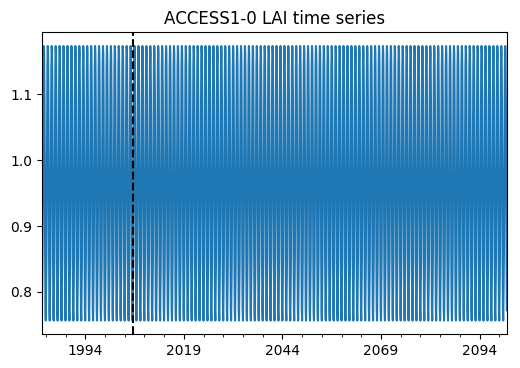

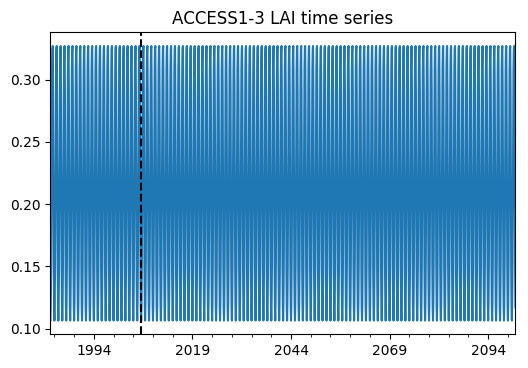

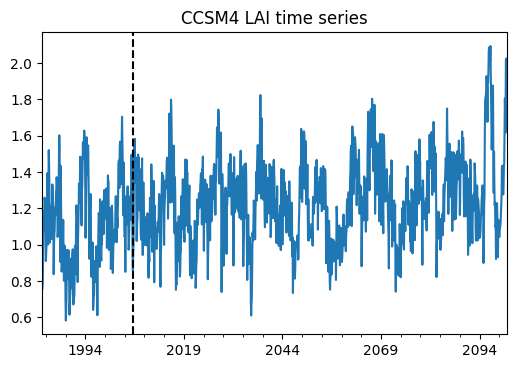

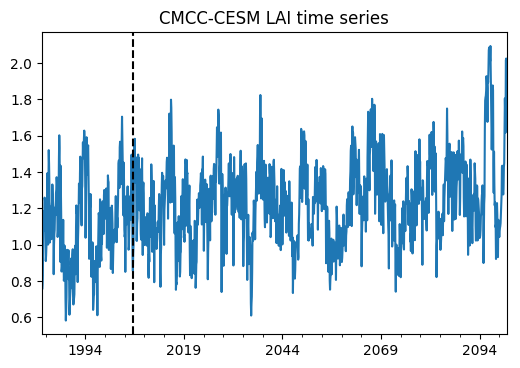

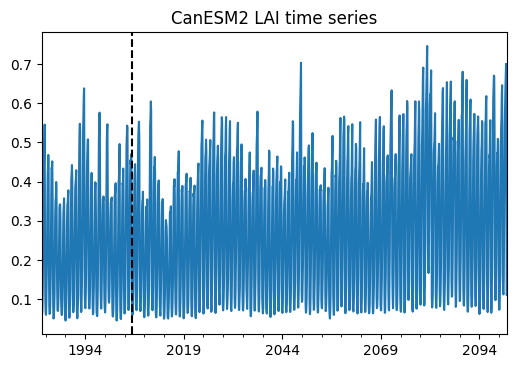

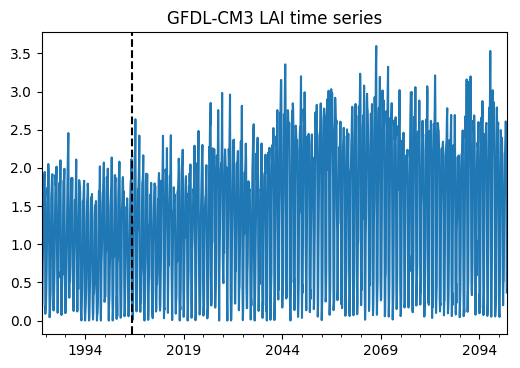

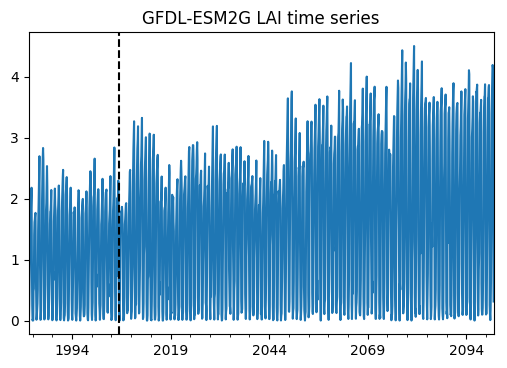

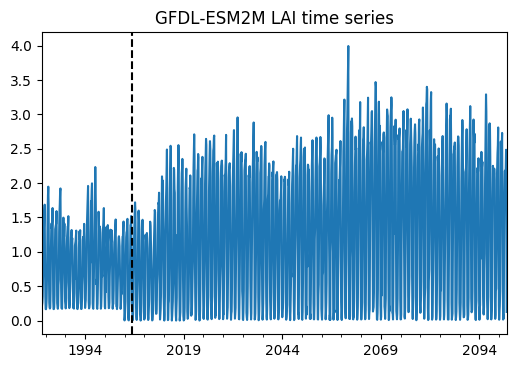

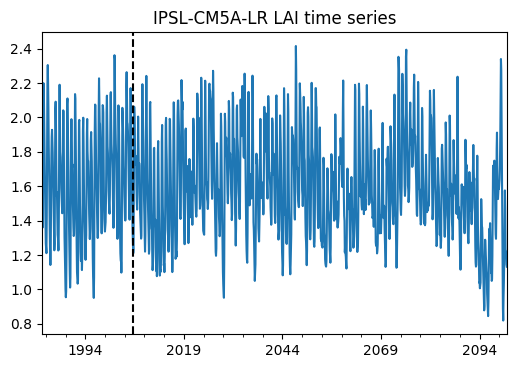

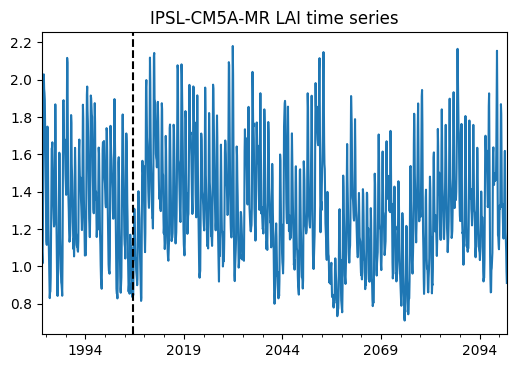

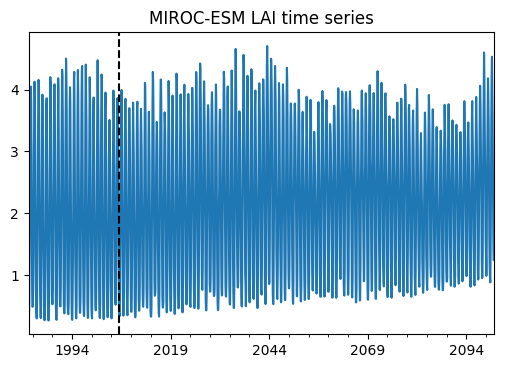

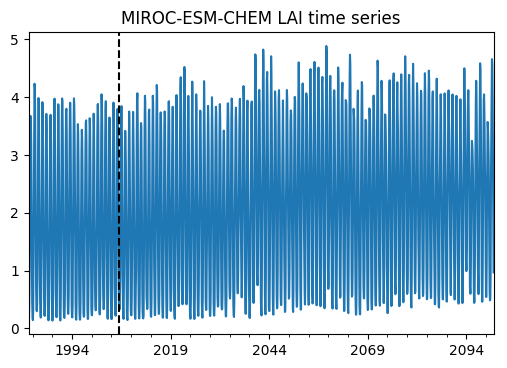

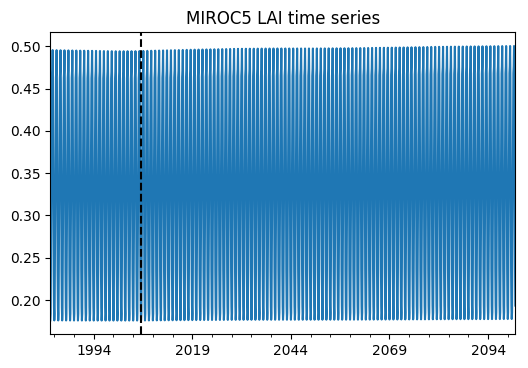

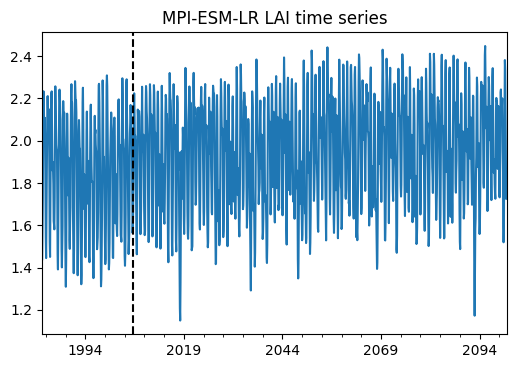

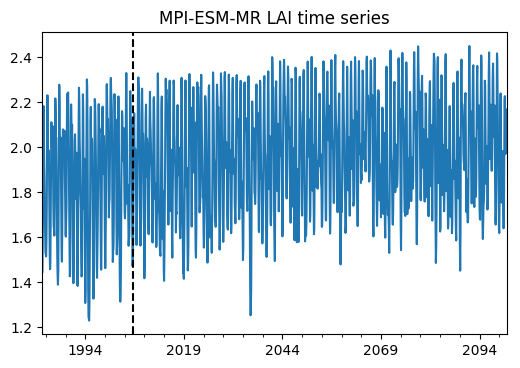

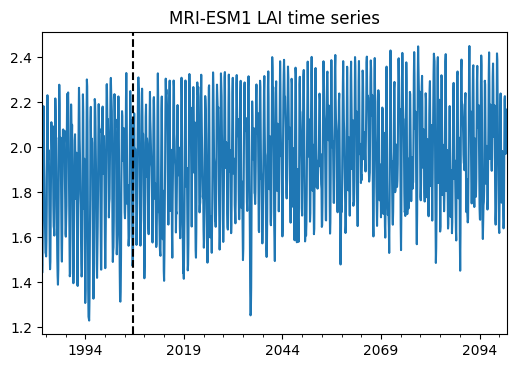

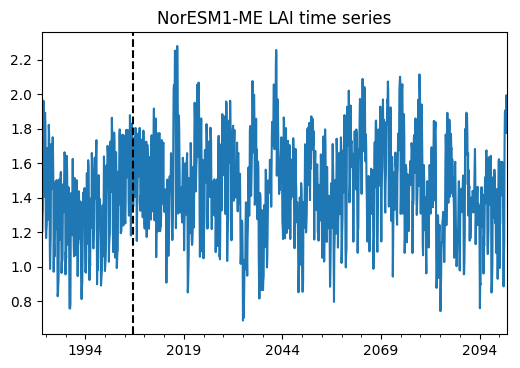

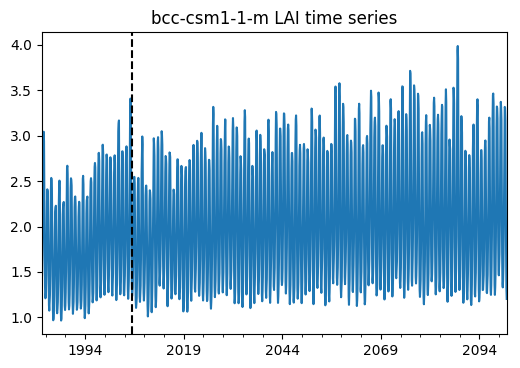

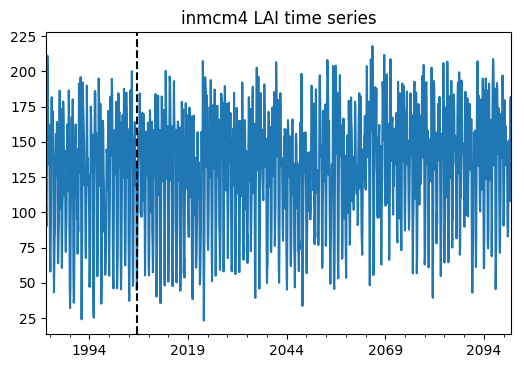

In [159]:
for model in models : 
    
    f= plt.figure(dpi=100)
    ax= plt.subplot(111)
    ax1 = lai_85_df[model].plot( ax=ax ) 
    plt.axvline(x=pd.datetime(2006, 1, 31), c="k", linestyle="--")
    plt.title("%s LAI time series" %model)
    plt.show()

Well, that is what these data look like, lets try and be smart about it. 